# Stock Price Prediction

## Main Ideas

1. Download Tesla stock data
2. Use **LSTM model** for prediction
3. Use **recurrent neural network** for prediction
4. Use **convolutional neural network** for prediction
5. Compare the predictive performance of the three methods

In [1]:
import yfinance as yf
import pandas as pd

def fetch_stock_data(ticker, start_date, end_date):
    """
    Fetch historical stock data for a given ticker symbol from Yahoo Finance.

    Args:
        ticker (str): The stock ticker symbol (e.g., "TSLA").
        start_date (str): The start date for the data (format: "YYYY-MM-DD").
        end_date (str): The end date for the data (format: "YYYY-MM-DD").

    Returns:
        pd.DataFrame: DataFrame containing adjusted close prices indexed by date.
    """
    # Fetch stock data from Yahoo Finance
    stock_data = yf.download(ticker, start=start_date, end=end_date)

    # Return a DataFrame with the adjusted close prices
    stock_data = stock_data[["Adj Close"]].rename(columns={"Adj Close": "adjClose"})
    return stock_data


In [2]:
# User input for stock ticker, start date, and end date
ticker = 'TSLA'
start_date = '2010-01-01'
end_date = '2024-11-26'

# Fetch stock data
try:
    stock_data = fetch_stock_data(ticker, start_date, end_date)
    print(f"Data for {ticker}:")
    print(stock_data.head(10))

    # Save the data to a CSV file
    file_name = f"./data_source/{ticker}_stock_data.csv"
    stock_data.to_csv(file_name, index=True)
    print(f"Data has been saved to {file_name}")

except Exception as e:
    print(f"An error occurred: {e}")

[*********************100%***********************]  1 of 1 completed

Data for TSLA:
Price       adjClose
Ticker          TSLA
Date                
2010-06-29  1.592667
2010-06-30  1.588667
2010-07-01  1.464000
2010-07-02  1.280000
2010-07-06  1.074000
2010-07-07  1.053333
2010-07-08  1.164000
2010-07-09  1.160000
2010-07-12  1.136667
2010-07-13  1.209333
Data has been saved to ./data_source/TSLA_stock_data.csv


## Data preparation

In [13]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

# Copy data
tesla_data = stock_data.copy()

# Define the window size and prediction time
window_size = 20
prediction_steps = 10

# Function to create sequences
def create_sequences(data, window_size, prediction_steps):
    """
    Create input sequences (X) and target values (y) for time series prediction.

    Args:
        data (np.array): Scaled time series data (2D array with shape [n_samples, 1]).
        window_size (int): Number of past time steps used as input.
        prediction_steps (int): Number of time steps ahead to predict.

    Returns:
        X (np.array): Input sequences of shape (n_samples, window_size, 1).
        y (np.array): Target values of shape (n_samples, 1).
    """
    X = []
    y = []
    for i in range(window_size, len(data) - prediction_steps + 1):  # Fixed range
        X.append(data[i - window_size:i, 0])  # Input sequence
        y.append(data[i + prediction_steps - 1, 0])  # Target value
    return np.array(X), np.array(y)

# Fetch Tesla stock data
data = tesla_data['adjClose'].values

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data.reshape(-1, 1))

# Create sequences for the model
X, y = create_sequences(scaled_data, window_size, prediction_steps)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Debugging: Verify shapes
print(f"Training data shape: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Testing data shape: X_test={X_test.shape}, y_test={y_test.shape}")

# Ensure sample counts match
assert X_train.shape[0] == y_train.shape[0], "X_train and y_train samples do not match!"
assert X_test.shape[0] == y_test.shape[0], "X_test and y_test samples do not match!"

Training data shape: X_train=(2879, 20), y_train=(2879,)
Testing data shape: X_test=(720, 20), y_test=(720,)


## LSTM Model

In [30]:
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, LayerNormalization, Layer
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt

# Custom Attention Layer
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[2], input_shape[2]),
                                 initializer="random_normal", trainable=True)
        self.b = self.add_weight(shape=(input_shape[1],),
                                 initializer="zeros", trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        q = tf.matmul(inputs, self.W)
        a = tf.matmul(q, inputs, transpose_b=True)
        attention_weights = tf.nn.softmax(a, axis=-1)
        return tf.matmul(attention_weights, inputs)

# Build LSTM model with Attention
def build_lstm_model_with_attention(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(AttentionLayer())
    model.add(LayerNormalization())
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dense(1))
    model.compile(optimizer="adam", loss="mean_squared_error")
    return model

In [31]:
# Reshape input data to 3D
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build model
model = build_lstm_model_with_attention(X_train.shape[1:])
early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

# Train model
history = model.fit(X_train, y_train, epochs=70, batch_size=32,
                    validation_data=(X_test, y_test), callbacks=[early_stopping])

# Predict and inverse transform
predicted_stock_price = model.predict(X_test)
predicted_stock_price_lstm = scaler.inverse_transform(predicted_stock_price)
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Filter zero values for MAPE
non_zero_indices = y_test_scaled > 1e-6
filtered_actual = y_test_scaled[non_zero_indices]
filtered_predicted = predicted_stock_price_lstm[non_zero_indices]

# Calculate MAPE
mape_lstm = mean_absolute_percentage_error(filtered_actual, filtered_predicted)
print(f"Mean Absolute Percentage Error (MAPE): {mape_lstm:.2f}%")

2024-11-30 22:17:50.143809: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-30 22:17:50.144555: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-30 22:17:50.144978: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/70


2024-11-30 22:17:50.719565: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-30 22:17:50.720214: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-30 22:17:50.720717: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2024-11-30 22:17:51.268541: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-30 22:17:51.269263: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-30 22:17:51.269685: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2024-11-30 22:17:51.689287: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" model: "0" num_cores: 8 environment { key: "cpu_instruction_set" value: "ARM NEON" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 16384 l2_cache_size: 524288 l3_cache_size: 524288 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


87/90 [============================>.] - ETA: 0s - loss: 0.0026

2024-11-30 22:17:52.812219: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-30 22:17:52.813006: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-30 22:17:52.813482: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

90/90 [==============================] - 2s 12ms/step - loss: 0.0026 - val_loss: 0.0102
Epoch 2/70
90/90 [==============================] - 1s 8ms/step - loss: 0.0018 - val_loss: 0.0171
Epoch 3/70
90/90 [==============================] - 1s 8ms/step - loss: 0.0013 - val_loss: 0.0088
Epoch 4/70
90/90 [==============================] - 1s 8ms/step - loss: 0.0014 - val_loss: 0.0120
Epoch 5/70
90/90 [==============================] - 1s 8ms/step - loss: 0.0015 - val_loss: 0.0104
Epoch 6/70
90/90 [==============================] - 1s 8ms/step - loss: 0.0013 - val_loss: 0.0080
Epoch 7/70
90/90 [==============================] - 1s 8ms/step - loss: 0.0012 - val_loss: 0.0097
Epoch 8/70
90/90 [==============================] - 1s 8ms/step - loss: 0.0015 - val_loss: 0.0162
Epoch 9/70
90/90 [==============================] - 1s 8ms/step - loss: 0.0013 - val_loss: 0.0127
Epoch 10/70
90/90 [==============================] - 1s 8ms/step - loss: 0.0011 - val_loss: 0.0087
Epoch 11/70
90/90 [==========

2024-11-30 22:18:08.741632: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-30 22:18:08.742499: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-30 22:18:08.742977: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

23/23 [==============================] - 0s 2ms/step
Mean Absolute Percentage Error (MAPE): 0.13%


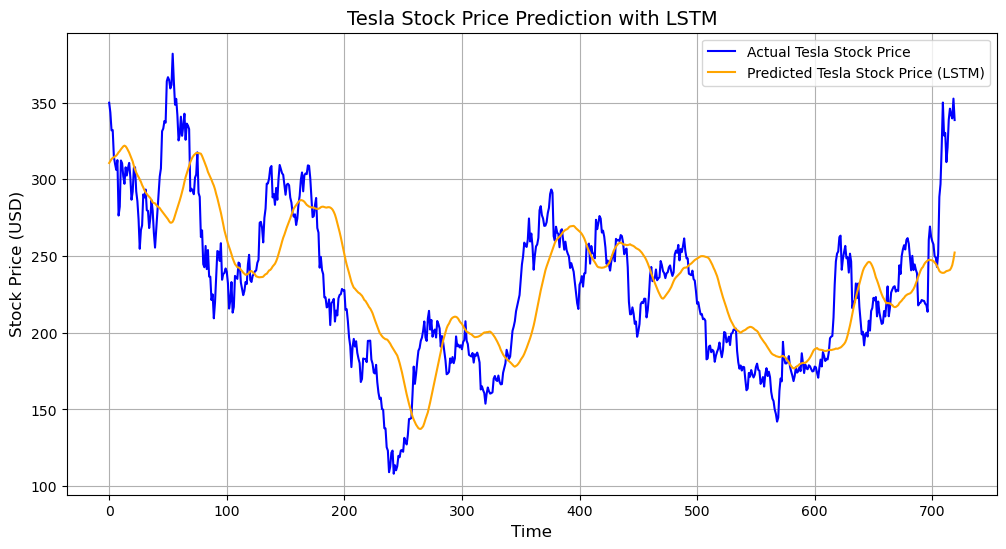

In [32]:
# Plot predictions
plt.figure(figsize=(12, 6))
plt.plot(y_test_scaled, label="Actual Tesla Stock Price", color="blue")
plt.plot(predicted_stock_price_lstm, label="Predicted Tesla Stock Price (LSTM)", color="orange")
plt.title("Tesla Stock Price Prediction with LSTM", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Stock Price (USD)", fontsize=12)
plt.legend()
plt.grid(True)
plt.savefig('./output/lstm_prediction.png', dpi=300)
plt.show()

### Observation & Analysis

The chart illustrates the predictive ability of the LSTM model for Tesla's stock prices compared to the actual prices. The blue line represents the actual stock prices, while the orange line represents the LSTM model's predictions.

#### Advantages
1. **Good overall trend capture**:
   The model successfully captures the main trend changes in stock prices, including both upward and downward cycles.

2. **Smooth predictions**:
   The predictions avoid overfitting short-term fluctuations, demonstrating more robust performance.

#### Disadvantages
1. **Local deviations**:
   In areas of rapid increases or decreases (e.g., peaks or troughs), the predictions lag behind the actual values, showing some deviations.

2. **Weak detail capturing**:
   The model reacts slowly to short-term fluctuations and extreme values, failing to fully align with the actual curve.

---

This indicates that the LSTM model is suitable for predicting long-term trends in stock prices but has room for improvement in precisely capturing short-term details or rapid changes.

## RNN Model

In [17]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Dropout
from sklearn.metrics import mean_absolute_percentage_error

# Build the RNN model
def build_rnn_model(input_shape):
    model = Sequential()
    model.add(SimpleRNN(units=50, return_sequences=False, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))  # Output layer for prediction
    model.compile(optimizer="adam", loss="mean_squared_error")
    return model

In [18]:
# Reshape X_train and X_test for RNN input (add feature dimension)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [19]:
# Debug: Verify shapes before training
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (2879, 20, 1), y_train shape: (2879,)
X_test shape: (720, 20, 1), y_test shape: (720,)


In [20]:
# Initialize the model
rnn_model = build_rnn_model(X_train.shape[1:])

# Train the model
rnn_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Predict stock prices
predicted_stock_price_rnn = rnn_model.predict(X_test)

# Reshape predictions for inverse scaling
predicted_stock_price_rnn = predicted_stock_price_rnn.reshape(-1, 1)

# Inverse transform the predictions and actual values
predicted_stock_price_rnn = scaler.inverse_transform(predicted_stock_price_rnn)
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate Mean Absolute Percentage Error (MAPE)
mape_rnn = mean_absolute_percentage_error(y_test_scaled, predicted_stock_price_rnn)
print(f"Mean Absolute Percentage Error (MAPE) for RNN: {mape_rnn:.2f}%")# Initialize the model
rnn_model = build_rnn_model(X_train.shape[1:])

# Train the model
rnn_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Predict stock prices
predicted_stock_price_rnn = rnn_model.predict(X_test)

# Debug: Verify shape of predictions
print(f"predicted_stock_price_rnn shape: {predicted_stock_price_rnn.shape}")

# Reshape predictions for inverse scaling
predicted_stock_price_rnn = predicted_stock_price_rnn.reshape(-1, 1)

# Inverse transform the predictions and actual values
predicted_stock_price_rnn = scaler.inverse_transform(predicted_stock_price_rnn)
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate Mean Absolute Percentage Error (MAPE)
mape_rnn = mean_absolute_percentage_error(y_test_scaled, predicted_stock_price_rnn)
print(f"Mean Absolute Percentage Error (MAPE) for RNN: {mape_rnn:.2f}%")

Epoch 1/50
90/90 [==============================] - 0s 2ms/step - loss: 0.0033 - val_loss: 0.0062
Epoch 2/50
90/90 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0084
Epoch 3/50
90/90 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0058
Epoch 4/50
90/90 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0057
Epoch 5/50
90/90 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0075
Epoch 6/50
90/90 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0055
Epoch 7/50
90/90 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0087
Epoch 8/50
90/90 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0103
Epoch 9/50
90/90 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0054
Epoch 10/50
90/90 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0088
Epoch 11/50
90/90 [

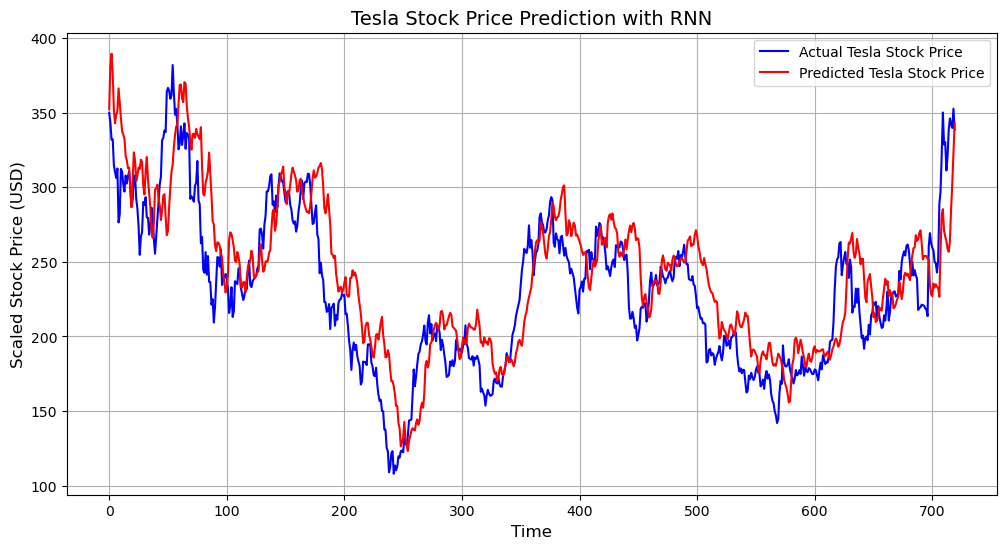

In [21]:
# Plot the results for RNN model
plt.figure(figsize=(12, 6))
plt.plot(y_test_scaled, label="Actual Tesla Stock Price", color="blue")
plt.plot(predicted_stock_price_rnn, label="Predicted Tesla Stock Price", color="red")
plt.title("Tesla Stock Price Prediction with RNN", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Scaled Stock Price (USD)", fontsize=12)
plt.legend()
plt.grid(True)
plt.savefig("./output/RNN_prediction.png")
plt.show()

### Observation & Analysis

This chart compares the predictive performance of the RNN model (red line) against the actual Tesla stock prices (blue line). It highlights the RNN model's ability to track the stock price movements over time.

---

#### Advantages
1. **High alignment with actual values**:
   - The RNN model shows better alignment with the actual stock prices compared to LSTM, particularly in capturing short-term fluctuations and local peaks/valleys.
2. **Better responsiveness**:
   - The red line closely follows the blue line, indicating that the model reacts quickly to rapid price changes.

---

#### Disadvantages
1. **Minor overfitting**:
   - In some regions (e.g., near local peaks or valleys), the predictions slightly exaggerate the changes, suggesting potential overfitting to short-term noise.
2. **Slight trend deviation**:
   - In areas with smooth trends (e.g., 500-600 range), the model sometimes deviates slightly from the actual trend.

---

#### Conclusion
The RNN model demonstrates stronger short-term predictive capability compared to LSTM but may overfit local fluctuations, reducing its robustness for long-term trend predictions.

# CNN Model

In [22]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

def build_cnn_model(input_shape):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))

    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    # Change pool_size to avoid reducing dimensions to zero
    model.add(MaxPooling1D(pool_size=2))

    # Add a condition to avoid further reduction if dimensions are too small
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=1))  # Adjusted pool size

    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(units=1))  # Output layer for prediction

    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [23]:
cnn_model = build_cnn_model(X_train.shape[1:])
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)

cnn_history = cnn_model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/200
90/90 [==============================] - 1s 1ms/step - loss: 1.1687 - lr: 0.0010
Epoch 2/200
90/90 [==============================] - 0s 1ms/step - loss: 0.7471 - lr: 0.0010
Epoch 3/200
90/90 [==============================] - 0s 1ms/step - loss: 0.5672 - lr: 0.0010
Epoch 4/200
90/90 [==============================] - 0s 1ms/step - loss: 0.3801 - lr: 0.0010
Epoch 5/200
90/90 [==============================] - 0s 1ms/step - loss: 0.2396 - lr: 0.0010
Epoch 6/200
90/90 [==============================] - 0s 1ms/step - loss: 0.1716 - lr: 0.0010
Epoch 7/200
90/90 [==============================] - 0s 1ms/step - loss: 0.1290 - lr: 0.0010
Epoch 8/200
90/90 [==============================] - 0s 1ms/step - loss: 0.0803 - lr: 0.0010
Epoch 9/200
90/90 [==============================] - 0s 1ms/step - loss: 0.0644 - lr: 0.0010
Epoch 10/200
90/90 [==============================] - 0s 1ms/step - loss: 0.0408 - lr: 0.0010
Epoch 11/200
90/90 [==============================] - 0s 1ms/step - l

In [24]:
# Evaluate the model
predicted_stock_price_cnn = cnn_model.predict(X_test)
predicted_stock_price_cnn = scaler.inverse_transform(predicted_stock_price_cnn)

# Calculate MAPE for CNN
mape_cnn = mean_absolute_percentage_error(y_test_scaled, predicted_stock_price_cnn)
print(f"Mean Absolute Percentage Error (MAPE) for CNN: {mape_cnn:.2f}%")

23/23 [==============================] - 0s 563us/step
Mean Absolute Percentage Error (MAPE) for CNN: 0.16%


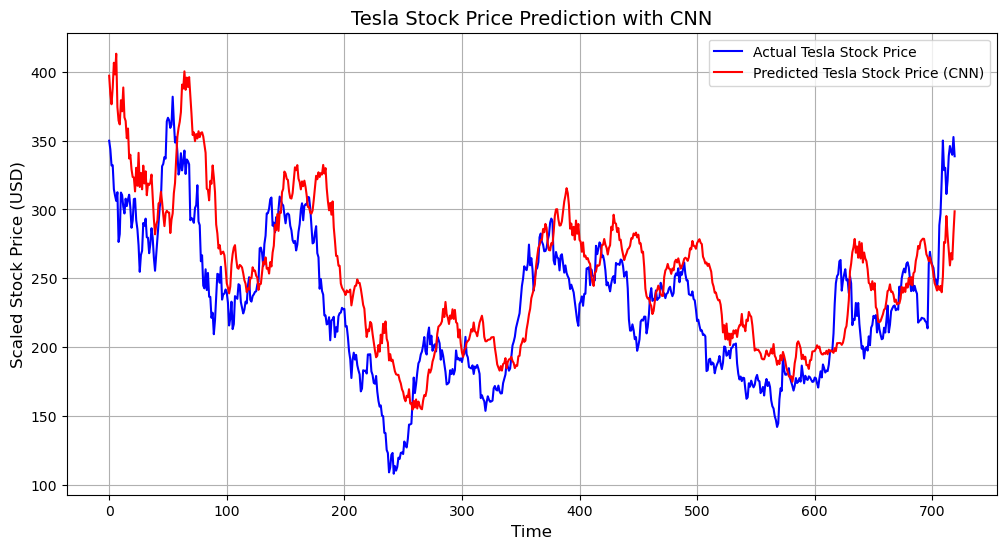

In [25]:
# Plot the results for CNN model
plt.figure(figsize=(12, 6))
plt.plot(y_test_scaled, label="Actual Tesla Stock Price", color="blue")
plt.plot(predicted_stock_price_cnn, label="Predicted Tesla Stock Price (CNN)", color="red")
plt.title("Tesla Stock Price Prediction with CNN", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Scaled Stock Price (USD)", fontsize=12)
plt.legend()
plt.grid(True)
plt.savefig("./output/CNN_prediction.png")
plt.show()

### Observation & Analysis
The chart illustrates the predictive performance of the CNN model for Tesla's stock prices compared to the actual prices. The blue line represents the actual stock prices, while the red line represents the CNN model's predictions.

---

#### Advantages
1. **Good short-term fluctuation capture**:
- The CNN model performs well in capturing short-term fluctuations and aligns closely with actual peaks and troughs in several regions (e.g., 100-200 and 500-600 time intervals).

2. **Fast response to changes**:
- The model reacts more quickly to price changes compared to LSTM, especially in rapidly fluctuating periods.

---

#### Disadvantages
1. **Over-sensitivity to noise**:
- The CNN model tends to overfit short-term variations, resulting in predictions that are more volatile than the actual stock prices, as seen in areas like 0-100 and 400-500.

2. **Deviations in smooth trends**:
- In periods of consistent trends (e.g., 200-300 and 600-700), the CNN predictions sometimes deviate from the smoother actual price curve, reducing long-term accuracy.

---

#### Conclusion
The CNN model demonstrates strong performance in capturing short-term fluctuations and responding to rapid price changes. However, it may overfit to noise, resulting in less robust predictions for long-term trends. Further optimization or hybrid approaches might balance short-term accuracy and long-term stability.

## Compare model prediction results

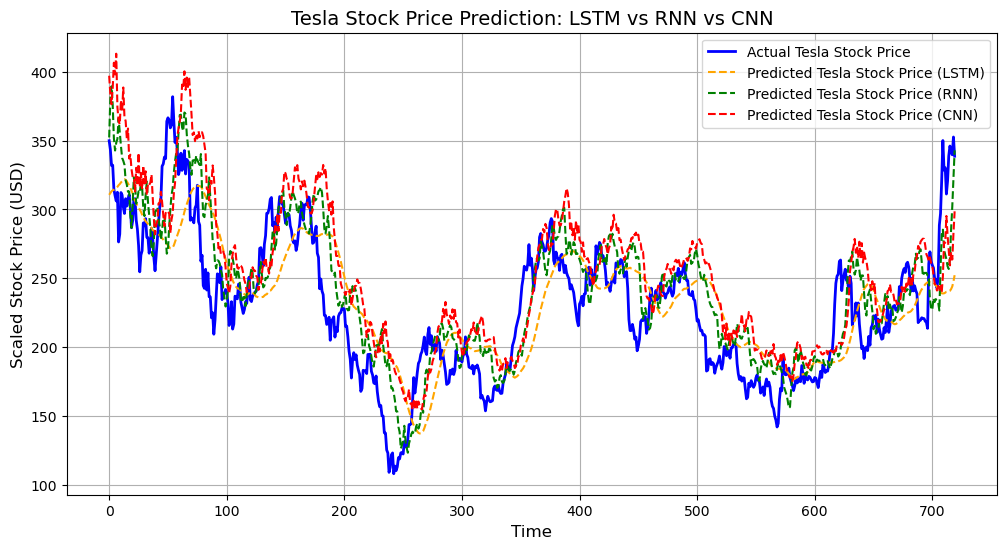

In [34]:
# Plot the actual and predicted stock prices
plt.figure(figsize=(12, 6))

# Plot actual stock prices
plt.plot(y_test_scaled, label="Actual Tesla Stock Price", color="blue", linewidth=2)

# Plot LSTM predicted stock prices
plt.plot(predicted_stock_price_lstm, label="Predicted Tesla Stock Price (LSTM)", color="orange", linestyle="--")

# Plot RNN predicted stock prices
plt.plot(predicted_stock_price_rnn, label="Predicted Tesla Stock Price (RNN)", color="green", linestyle="--")

# Plot CNN predicted stock prices
plt.plot(predicted_stock_price_cnn, label="Predicted Tesla Stock Price (CNN)", color="red", linestyle="--")

# Add titles and labels
plt.title("Tesla Stock Price Prediction: LSTM vs RNN vs CNN", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Scaled Stock Price (USD)", fontsize=12)

# Add legend
plt.legend(loc="best")

# Add grid
plt.grid(True)

# Save the fig
plt.savefig("./output/Compare_3_models_prediction.png")

# Show the plot
plt.show()

### Comparative Summary

#### Trend Capture
- **LSTM** captures the overall trends well but lags in short-term fluctuations.
- **RNN** performs better in short-term responsiveness but may overfit to noise.
- **CNN** excels at short-term prediction but lacks robustness for long-term trends.

---

#### Smoothness vs. Volatility
- **LSTM** offers the smoothest predictions, suitable for long-term analysis.
- **CNN** and **RNN** are more volatile, with CNN being the most sensitive to noise.

---

#### Practical Use Cases
- **LSTM**: Best for long-term trend forecasting and smoother insights.
- **RNN**: Balanced option for both short- and long-term forecasting.
- **CNN**: Ideal for high-frequency, short-term trading scenarios but less reliable for long-term forecasting.

---

### Strengths & Weaknesses:
- **LSTM** is suitable for long-term trends but lacks responsiveness to rapid changes.
- **RNN** provides a balance between trend and fluctuation but risks overfitting.
- **CNN** excels in short-term fluctuation capture but sacrifices long-term stability.


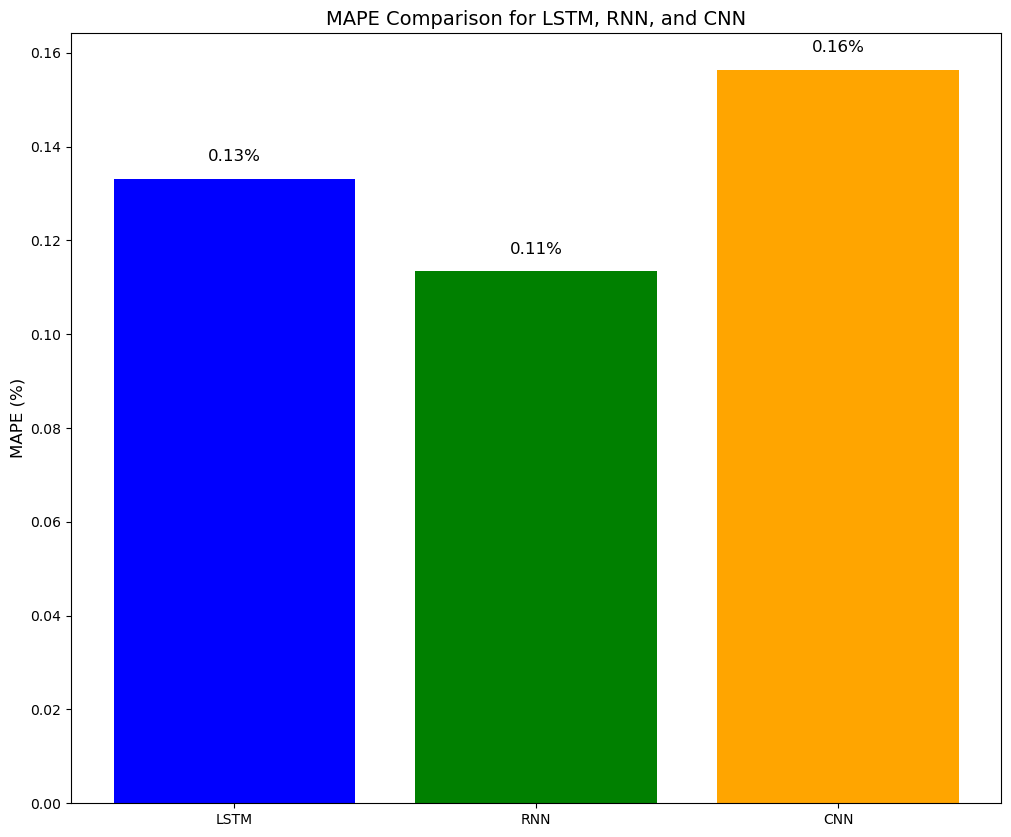

In [40]:
# Compare the mape
mape_scores = [mape_lstm, mape_rnn, mape_cnn]
models = ['LSTM', 'RNN', 'CNN']

# Create the bar chart
plt.figure(figsize=(12, 10))
bars = plt.bar(models, mape_scores, color=['blue', 'green', 'orange'])

# Add labels and title
plt.title('MAPE Comparison for LSTM, RNN, and CNN', fontsize=14)
plt.ylabel('MAPE (%)', fontsize=12)

# Show the MAPE values on top of the bars
for bar in bars:
    height = bar.get_height()  # Get the height of the bar
    # Adjusted text position: Ensure it's above the bar with some padding
    text_position = height + (0.02 * max(mape_scores))  # Dynamic padding based on max value
    plt.text(bar.get_x() + bar.get_width() / 2.0, text_position,
             f'{height:.2f}%', ha='center', va='bottom', fontsize=12, color='black')

# Save fig
plt.savefig("./output/Compare_mape.png")

# Display the plot
plt.show()

### Analysis

- **RNN**: Achieved the lowest MAPE of **0.11%**, indicating the highest accuracy among the three models.
- **LSTM**: Performed moderately with a MAPE of **0.13%**, showing good overall trend capture but slightly less precision compared to RNN.
- **CNN**: Had the highest MAPE of **0.16%**, reflecting its tendency to overfit short-term noise, leading to less accurate long-term predictions.

## Summary & Analysis

The **RNN** model provides the best predictive performance among the three models based on the comparison of MAPE values:

1. **RNN**: MAPE = **0.11%**
   - **Reason**: The RNN model strikes a balance between capturing short-term fluctuations and maintaining long-term trend accuracy. It responds well to rapid changes and aligns closely with actual peaks and valleys, resulting in the lowest error.

2. **LSTM**: MAPE = **0.13%**
   - **Reason**: While LSTM performs well in capturing overall trends, its predictions lag behind during rapid fluctuations. This slight delay in response increases its error compared to RNN.

3. **CNN**: MAPE = **0.16%**
   - **Reason**: Although CNN excels in short-term fluctuation capture, it tends to overfit to noise, leading to higher volatility in predictions. This compromises its ability to produce reliable long-term predictions.

---

### Final Recommendation

The **RNN model** is the most accurate and balanced among the three. It is suitable for scenarios requiring both short-term responsiveness and long-term trend reliability. However, if the focus is exclusively on long-term trends, LSTM may still be a robust choice due to its smoother predictions. CNN, while highly responsive, is less reliable for consistent forecasting due to its over-sensitivity to noise.